# Machine learning notebook

## Data prep

### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### Loading Data and visualization

From the directory, load the data

In [2]:
labels = ['BACTERIA', 'NORMAL', 'VIRUS']
directories = ['NORMAL', 'PNEUMONIA']
img_size = 100
def get_training_data(data_dir):
    data = [] 
    for directory in directories: 
        path = data_dir+"/"+directory
        if (directory == 'NORMAL'):
            class_num = 0
        else:
            class_num = -1
        for img in os.listdir(path):
            try:
                if (directory == 'NORMAL'): ## deciding on the class number
                    class_num = 0
                else:
                    if "bacteria" in img:
                        class_num = 1
                    else:
                        class_num = 2
                
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])               
                
                
            except Exception as e:
                print(e)
                
    return data

cell done running


Data is the loaded the data. Then the structure of a sample of the data is shown, and and image is plotted from it.

[array([[31, 32, 31, ..., 30, 31, 33],
       [33, 30, 28, ..., 30, 30, 31],
       [30, 31, 28, ..., 32, 33, 32],
       ...,
       [31, 29, 27, ..., 34, 33, 36],
       [28, 27, 27, ..., 33, 32, 35],
       [31, 28, 29, ..., 38, 34, 34]], dtype=uint8), 0]


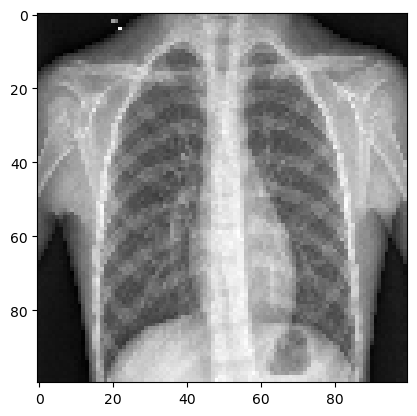

In [3]:
data = get_training_data('C:/Users/yeska/Documents/master/ml/project/images/chest_xray/code_test')
print(data[0])
plt.imshow(data[0][0], cmap='gray')

Below shows the count of each class

C:\Users\yeska\anaconda3\envs\machineLearningCourse\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\yeska\anaconda3\envs\machineLearningCourse\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\yeska\anaconda3\envs\machineLearningCourse\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\yeska\anaconda3\envs\machineLearningCourse\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be rem

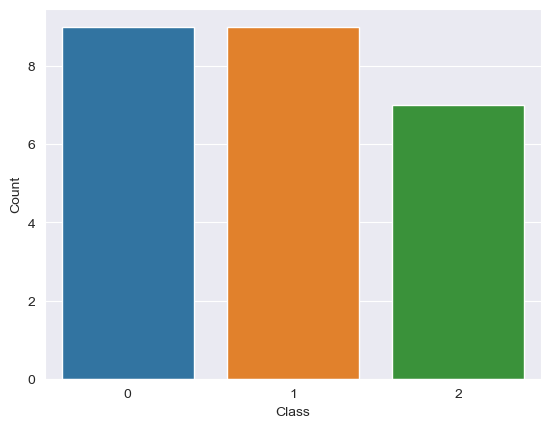

In [4]:
labels = [item[1] for item in data]
sns.set_style('darkgrid')
sns.countplot(x=labels)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

This is dividing the data into x and y. A printout of a sample is also provided for visualization.

In [5]:
#pdata = np.array(data)
x_train = []
y_train = []

for feature, label in data:
    x_train.append(feature)
    y_train.append(label)

print(x_train[0])
print(y_train[0])

[[31 32 31 ... 30 31 33]
 [33 30 28 ... 30 30 31]
 [30 31 28 ... 32 33 32]
 ...
 [31 29 27 ... 34 33 36]
 [28 27 27 ... 33 32 35]
 [31 28 29 ... 38 34 34]]
0


Normalization is done here, and again a printout to show.

In [32]:
x_train = np.array(x_train)/255 
print(x_train[0])

[[0.00047674 0.00049212 0.00047674 ... 0.00046136 0.00047674 0.0005075 ]
 [0.0005075  0.00046136 0.0004306  ... 0.00046136 0.00046136 0.00047674]
 [0.00046136 0.00047674 0.0004306  ... 0.00049212 0.0005075  0.00049212]
 ...
 [0.00047674 0.00044598 0.00041522 ... 0.00052288 0.0005075  0.00055363]
 [0.0004306  0.00041522 0.00041522 ... 0.0005075  0.00049212 0.00053825]
 [0.00047674 0.0004306  0.00044598 ... 0.00058439 0.00052288 0.00052288]]


### Data Augmentation

Reshaping, this is necessary for data augmentation. It might also be necessary for some model fitting.

In [35]:
x_train_reshaped = x_train.reshape(-1, img_size, img_size, 1) #apparently needed for CNN
y_train = np.array(y_train)

In [36]:
print(x_train_reshaped.shape)
print(x_train.shape)


(25, 100, 100, 1)
(25, 100, 100)


This is the image data generator from keras. This is basically the setting of the data augmentation. Here we have set it to only zoom and flip.

In [75]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#datagen.fit(x_train_reshaped)

A bit of visualization of how one image can be augmented using the settings.

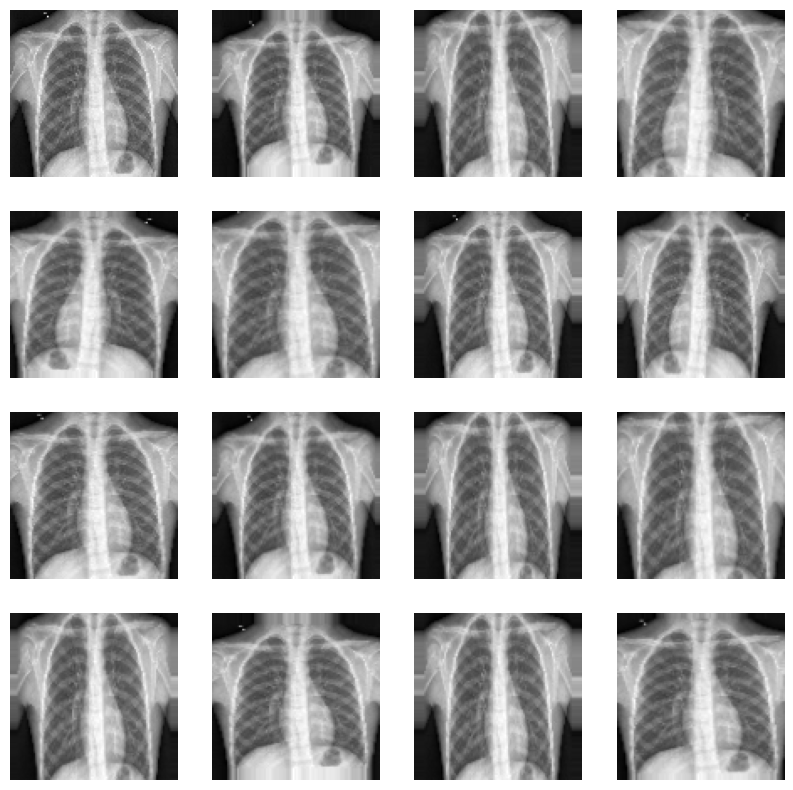

In [76]:
augmented_images = []

# Loop through each image
'''
for img_array in x_train_reshaped:
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        augmented_images.append(batch[0])
        i += 1
        if i >= 1:  # Generate 1 augmented image per original image
            break
'''

img_array = x_train_reshaped[0]
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

generator = datagen.flow(img_array, batch_size=1)
'''
for batch in datagen.flow(img_array, batch_size=1):
    
    //print("batch:", x_batch)
    i += 1
    if i >= 1:  
        break
'''
plt.figure(figsize=(10, 10))

plt.subplot(4, 4, 1)
plt.imshow(img_array[0, :, :, 0], cmap='gray')  # Assuming images are grayscale
plt.axis('off')

i = 0
for b in generator:
    plt.subplot(4, 4, i+2)
    plt.imshow(b[0, :, :, 0], cmap='gray')  # Assuming images are grayscale
    plt.axis('off')
    i += 1
    if i >= 15:
        break


plt.show()
